In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import recall_score,accuracy_score,roc_auc_score,average_precision_score,roc_curve,auc,confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.datasets import make_imbalance
import shap





/Users/ajung17/Python/Dharma-AppendicitisModel/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df_base=pd.read_excel('dataset_combined.xlsx',sheet_name=0)

df_base = df_base.dropna(subset=['Diagnosis'])

mapping={
    'no':0,
    'yes':1,
    'male':1,
    'female':0,
    'normal':0,
    'diarrhea':1,
    'constipation':1,
    '+':1,
    '++':2,
    '+++':3,
    'local':1,
    'generalized':2,
    'appendicitis':1,
    'no appendicitis':0,
    'uncomplicated':0,
    'complicated':1,
}

for col in df_base.columns:
    df_base[col]=df_base[col].replace(mapping).fillna(0)

print(df_base.shape)

df=df_base[df_base['Diagnosis']==1]

print(df['Severity'].value_counts(dropna=False))

df.to_excel('dataset_complications.xlsx', index=False)


feature_active=['Nausea','Loss_of_Appetite','Peritonitis','Ketones_in_Urine','Free_Fluids','CRP','WBC_Count','Body_Temperature','Appendix_Diameter','Severity']


# feature_roster=['Peritonitis','Ketones_in_Urine','Nausea','Loss_of_Appetite','Free_Fluids','CRP','WBC_Count','Body_Temperature','Neutrophil_Percentage','Appendix_Diameter','Severity']

# print (df['Severity'].value_counts())
# print (df_base['Diagnosis'].value_counts())

(1015, 17)
Severity
0    454
1    148
Name: count, dtype: int64


In [3]:
# Model Development

df=df[feature_active]

x = df.iloc[:, 0:-1]  
y = df.iloc[:, -1]



x_temp,x_test, y_temp,y_test = train_test_split(x,y,test_size=0.2,random_state=17)


smote = SMOTE(sampling_strategy='auto', random_state=17)

# Apply SMOTE to the training data
x_temp_resampled, y_temp_resampled = smote.fit_resample(x_temp, y_temp)

# Check the distribution after resampling
print("Before SMOTE: ", y_temp.value_counts())
print("After SMOTE: ", y_temp_resampled.value_counts())


majority_class_size = y_temp_resampled.value_counts()[0]
desired_majority_size = majority_class_size // 2  # Reducing class 0 to half its size
nearmiss = NearMiss(version=1,sampling_strategy={0: desired_majority_size})

x_temp_resampled_nearmiss, y_temp_resampled_nearmiss = nearmiss.fit_resample(x_temp_resampled, y_temp_resampled)

# Distribution after NearMiss undersampling
print("After NearMiss (undersampling class 0 to half): ", y_temp_resampled_nearmiss.value_counts())

x_train,x_val,y_train,y_val = train_test_split(x_temp_resampled_nearmiss,y_temp_resampled_nearmiss,test_size=0.25,random_state=17)

print("train dataset: ", y_train.value_counts())
print("validation dataset: ", y_val.value_counts())
print("test dataset: ", y_test.value_counts())



dharma=RandomForestClassifier(
    n_estimators=555,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=33,
    random_state=17,
   
)

dharma.fit(x_train,y_train)
scores = cross_val_score(dharma, x_train, y_train, cv=10, scoring='recall', n_jobs=2)

print("Mean cross_val recall Score :", scores.mean())
print("Standard Deviation of cross_val recall Scores:", scores.std())

scores_auc = cross_val_score(dharma, x_train, y_train, cv=10, scoring='roc_auc', n_jobs=2)
print("Mean cross_val auc-roc score:", scores_auc.mean())
print("Standard Deviation of auc-roc Scores:", scores_auc.std())










Before SMOTE:  Severity
0    359
1    122
Name: count, dtype: int64
After SMOTE:  Severity
0    359
1    359
Name: count, dtype: int64
After NearMiss (undersampling class 0 to half):  Severity
1    359
0    179
Name: count, dtype: int64
train dataset:  Severity
1    262
0    141
Name: count, dtype: int64
validation dataset:  Severity
1    97
0    38
Name: count, dtype: int64
test dataset:  Severity
0    95
1    26
Name: count, dtype: int64
Mean cross_val recall Score : 0.9314814814814815
Standard Deviation of cross_val recall Scores: 0.05061472263403439
Mean cross_val auc-roc score: 0.9795075295075295
Standard Deviation of auc-roc Scores: 0.013709194147772533


In [4]:
dharma.fit(x_train,y_train)

y_pred_prob=dharma.predict_proba(x_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

distances = np.sqrt((1 - tpr)**2 + fpr**2)
optimal_idx_eu = np.argmin(distances)
optimal_threshold_eu = thresholds[optimal_idx_eu]

print(f"Optimal Threshold Youden: {optimal_threshold} and Optimal Euclidean Distance :{optimal_threshold_eu}")

threshold_y = optimal_threshold
threshold_eu = optimal_threshold_eu

# threshold_eu=0.5

y_val_prob=dharma.predict_proba(x_val)[:,1]
y_thres=(y_val_prob >= threshold_y).astype(int)
auc_score = roc_auc_score(y_val, y_val_prob)
print("Val AUC:", auc_score)
val_conf_matrix = confusion_matrix(y_val, y_thres)
TNv, FPv, FNv, TPv = val_conf_matrix.ravel()
val_sensitivity = TPv / (TPv + FNv)
val_specificity = TNv / (TNv + FPv)
val_ppv = TPv/(TPv+FPv)
val_npv = TNv/(TNv+FNv)

print("For Youden Index")

print(f"Sensitivity: {val_sensitivity:.3f} ({val_sensitivity * 100:.2f}%)")
print(f"Specificity: {val_specificity:.3f} ({val_specificity * 100:.2f}%)")

print (f"Positive predictive value : {val_ppv:.3f}({val_ppv*100:.2f}%)")
print (f"Negative predictive value : {val_npv:.3f}({val_npv*100:.2f}%)")

print("Val Confusion Matrix:\n", val_conf_matrix)
val_acu=accuracy_score(y_val,y_thres)
print("Val accuracy score:",val_acu)

y_val_prob=dharma.predict_proba(x_val)[:,1]
y_thres=(y_val_prob >= threshold_eu).astype(int)
auc_score = roc_auc_score(y_val, y_val_prob)
print("Val AUC:", auc_score)
val_conf_matrix = confusion_matrix(y_val, y_thres)
TNv, FPv, FNv, TPv = val_conf_matrix.ravel()
val_sensitivity = TPv / (TPv + FNv)
val_specificity = TNv / (TNv + FPv)
val_ppv = TPv/(TPv+FPv)
val_npv = TNv/(TNv+FNv)

print("For Eucledean distance")

print(f"Sensitivity: {val_sensitivity:.3f} ({val_sensitivity * 100:.2f}%)")
print(f"Specificity: {val_specificity:.3f} ({val_specificity * 100:.2f}%)")

print (f"Positive predictive value : {val_ppv:.3f}({val_ppv*100:.2f}%)")
print (f"Negative predictive value : {val_npv:.3f}({val_npv*100:.2f}%)")

print("Val Confusion Matrix:\n", val_conf_matrix)
val_acu=accuracy_score(y_val,y_thres)
print("Val accuracy score:",val_acu)


Optimal Threshold Youden: 0.5495495495495496 and Optimal Euclidean Distance :0.5495495495495496
Val AUC: 0.9702930005425936
For Youden Index
Sensitivity: 0.928 (92.78%)
Specificity: 0.947 (94.74%)
Positive predictive value : 0.978(97.83%)
Negative predictive value : 0.837(83.72%)
Val Confusion Matrix:
 [[36  2]
 [ 7 90]]
Val accuracy score: 0.9333333333333333
Val AUC: 0.9702930005425936
For Eucledean distance
Sensitivity: 0.928 (92.78%)
Specificity: 0.947 (94.74%)
Positive predictive value : 0.978(97.83%)
Negative predictive value : 0.837(83.72%)
Val Confusion Matrix:
 [[36  2]
 [ 7 90]]
Val accuracy score: 0.9333333333333333


In [5]:
# # # Testing
threshold=threshold_y

dharma.fit(x_train,y_train)#Complications model

y_test=np.ravel(y_test)
dharma_prob=dharma.predict_proba(x_test)[:,1]
dharma_predict=(dharma_prob>=threshold).astype(int)
# dharma_predict=dharma.predict(x_test)

auc_score = roc_auc_score(y_test, dharma_prob)
print("AUC:", auc_score)
conf_matrix = confusion_matrix(y_test, dharma_predict)
TNv, FPv, FNv, TPv = conf_matrix.ravel()
sensitivity = TPv / (TPv + FNv)
specificity = TNv / (TNv + FPv)
ppv = TPv/(TPv+FPv)
npv = TNv/(TNv+FNv)


print(f"Sensitivity: {sensitivity:.3f} ({sensitivity * 100:.2f}%)")
print(f"Specificity: {specificity:.3f} ({specificity * 100:.2f}%)")

print (f"Positive predictive value : {ppv:.3f}({ppv*100:.2f}%)")
print (f"Negative predictive value : {npv:.3f}({npv*100:.2f}%)")

print("Confusion Matrix:\n", conf_matrix)


AUC: 0.8720647773279352
Sensitivity: 0.962 (96.15%)
Specificity: 0.642 (64.21%)
Positive predictive value : 0.424(42.37%)
Negative predictive value : 0.984(98.39%)
Confusion Matrix:
 [[61 34]
 [ 1 25]]


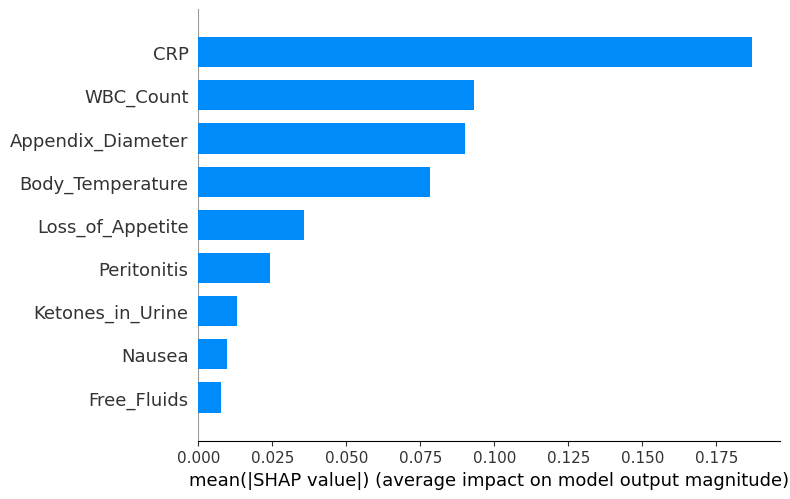

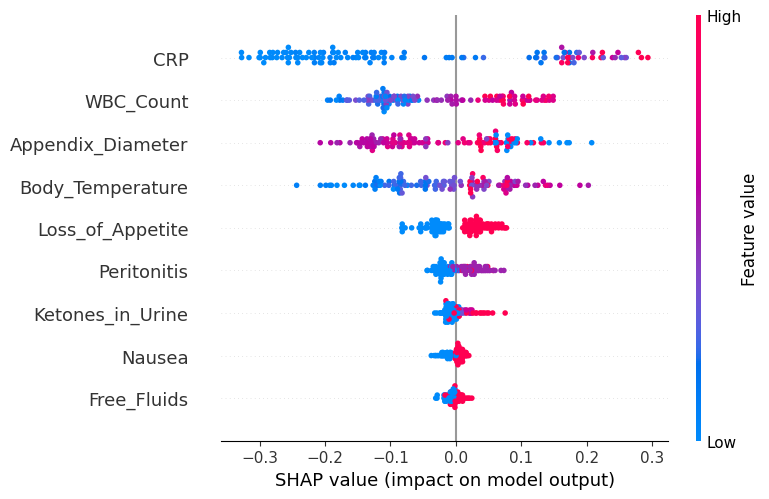

base value: 0.6494713075358228
             Feature  Importance
5                CRP    0.356112
8  Appendix_Diameter    0.176411
6          WBC_Count    0.174539
7   Body_Temperature    0.169703
1   Loss_of_Appetite    0.037974
2        Peritonitis    0.031184
3   Ketones_in_Urine    0.025525
4        Free_Fluids    0.014907
0             Nausea    0.013645


In [6]:
# Explainability of the model

# SHAP explanation
explainer=shap.TreeExplainer(dharma)
shap_values=explainer.shap_values(x_test)
shap.summary_plot(shap_values[:,:,1],x_test,plot_type="bar",max_display=10)
shap.summary_plot(shap_values[:,:,1],x_test,plot_type="dot",max_display=10)
base_values=explainer.expected_value[1]
print("base value:",base_values)

# Feature importance
importances = dharma.feature_importances_
feature_importances_df=pd.DataFrame({
    'Feature': x_test.columns,
    'Importance': importances
})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)